<a href="https://colab.research.google.com/github/Bhimsendabby/ImageColorization/blob/main/ImageColorizationUsingAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir /content/.kaggle

In [ ]:
!chmod 600 /content/kaggle/kaggle.json

In [32]:
!kaggle datasets download -d pavansanagapati/images-dataset

Dataset URL: https://www.kaggle.com/datasets/pavansanagapati/images-dataset
License(s): CC0-1.0
100% 1.01G/1.01G [00:47<00:00, 24.4MB/s]
100% 1.01G/1.01G [00:47<00:00, 22.7MB/s]


In [33]:
!unzip images-dataset.zip

Archive:  images-dataset.zip
  inflating: data/bike/bike_001.bmp  
  inflating: data/bike/bike_002.bmp  
  inflating: data/bike/bike_003.bmp  
  inflating: data/bike/bike_004.bmp  
  inflating: data/bike/bike_005.bmp  
  inflating: data/bike/bike_006.bmp  
  inflating: data/bike/bike_007.bmp  
  inflating: data/bike/bike_008.bmp  
  inflating: data/bike/bike_009.bmp  
  inflating: data/bike/bike_010.bmp  
  inflating: data/bike/bike_011.bmp  
  inflating: data/bike/bike_012.bmp  
  inflating: data/bike/bike_013.bmp  
  inflating: data/bike/bike_014.bmp  
  inflating: data/bike/bike_015.bmp  
  inflating: data/bike/bike_016.bmp  
  inflating: data/bike/bike_017.bmp  
  inflating: data/bike/bike_018.bmp  
  inflating: data/bike/bike_019.bmp  
  inflating: data/bike/bike_020.bmp  
  inflating: data/bike/bike_021.bmp  
  inflating: data/bike/bike_022.bmp  
  inflating: data/bike/bike_023.bmp  
  inflating: data/bike/bike_024.bmp  
  inflating: data/bike/bike_025.bmp  
  inflating: data/bik

In [34]:
!kaggle datasets download -d jehanbhathena/weather-dataset

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0
100% 584M/587M [00:21<00:00, 28.7MB/s]
100% 587M/587M [00:21<00:00, 29.0MB/s]


In [35]:
!unzip weather-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/frost/3913.jpg  
  inflating: dataset/frost/3914.jpg  
  inflating: dataset/frost/3915.jpg  
  inflating: dataset/frost/3916.jpg  
  inflating: dataset/frost/3917.jpg  
  inflating: dataset/frost/3918.jpg  
  inflating: dataset/frost/3919.jpg  
  inflating: dataset/frost/3920.jpg  
  inflating: dataset/frost/3921.jpg  
  inflating: dataset/frost/3922.jpg  
  inflating: dataset/frost/3923.jpg  
  inflating: dataset/frost/3924.jpg  
  inflating: dataset/frost/3925.jpg  
  inflating: dataset/frost/3926.jpg  
  inflating: dataset/frost/3927.jpg  
  inflating: dataset/frost/3928.jpg  
  inflating: dataset/frost/3929.jpg  
  inflating: dataset/frost/3930.jpg  
  inflating: dataset/frost/3931.jpg  
  inflating: dataset/frost/3932.jpg  
  inflating: dataset/frost/3933.jpg  
  inflating: dataset/frost/3934.jpg  
  inflating: dataset/frost/3935.jpg  
  inflating: dataset/frost/3936.jpg  
  inflating: dataset/frost/3937.jpg  

In [42]:
import numpy as np
import pandas as pd
import matplotlib as plt
import cv2
import os
import zipfile
import matplotlib.pyplot as plt
import os
import PIL
import keras
import tensorflow as tf
from keras import layers, models
import time
from IPython import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave

#path to the directories
categories_1 = ['bike','cars','cats','data','dogs','flowers','horses','human']

#path to the directories
categories_1 = ['dew','fogsmog','frost','glaze','hail','lightning','rain','rainbow','rime','sandstorm','snow']

#Set the image size
IMAGE_SIZE = 224

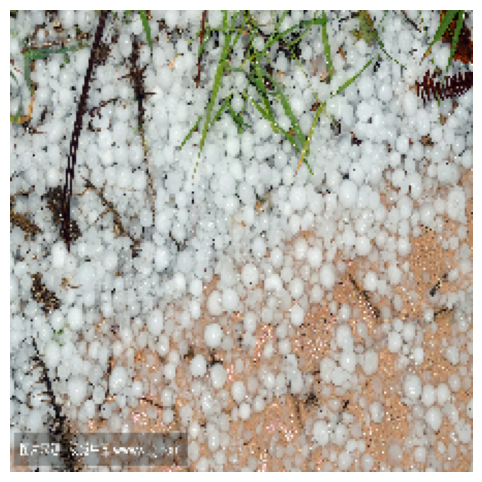

In [43]:
img = load_img("/content/dataset/hail/0002.jpg",target_size=(IMAGE_SIZE, IMAGE_SIZE))
x = img_to_array(img)

# Display some images
fig = plt.figure(figsize=(12, 6))  # Adjust width and height as needed

plt.imshow(img)
plt.axis('off')

plt.show()

In [44]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
train = train_datagen.flow_from_directory("/content/data",
                                          target_size=(256, 256),
                                          batch_size=340,
                                          class_mode=None)

Found 3606 images belonging to 8 classes.
